In [ ]:
Collect beta angle information from CSV

In [1]:
import pandas as pd
solar_angle_data = pd.read_csv("Halfhour_Ukpik-1_Beta_Angle_AprMay2022.csv")
beta_angles = solar_angle_data['Beta Angle (deg)']
dates = solar_angle_data['Time (UTCG)']
dates

0       2022-04-01 12:00:00 AM
1       2022-04-01 12:30:00 AM
2        2022-04-01 1:00:00 AM
3        2022-04-01 1:30:00 AM
4        2022-04-01 2:00:00 AM
                 ...          
1436    2022-04-30 10:00:00 PM
1437    2022-04-30 10:30:00 PM
1438    2022-04-30 11:00:00 PM
1439    2022-04-30 11:30:00 PM
1440    2022-05-01 12:00:00 AM
Name: Time (UTCG), Length: 1441, dtype: object

In [ ]:
Every 90-minute orbit, 30 minutes of eclipse. Beta angles change by the half-hour, 
based on format of data, can assume every 3 samples correspond to single orbit.
Analysis therefore done over n/3 orbits, where n defined by number of beta-angle recordings from STK sim

In [2]:
import math
import matplotlib.pyplot as plt
solar_irradiance = 1380
area = 0.003
efficiency = 0.24
solar_power = []
total_solar_power = 0

samples = len(beta_angles)
orbits = samples/3

iterator = []
iterator_orbits = []
orbit_angles = []

for i in range(samples):
    
    if i % 3 == 0:  #For every third data-sample, satellite enters eclipse thus zero power generated
        solar_power.append(0)
        iterator_orbits.append(i/3)
        orbit_angles.append(beta_angles[i])
        
    #For nominal operation, power is generated
    else:
        
        #Convert to mWh and quadruple as four cells per panel 
        #Take beta-angle at iteration & factor into power gen eqn
        #Angles in data never exceed range: [-90, 90], no need to account for out-of-range case  
        solar_power.append(solar_irradiance * area * efficiency * math.cos(beta_angles[i]*math.pi/180) * 4 * 1000)
        
        #In case of negative beta angles, satellite should generate power
        if(solar_power[i] < 0):
            solar_power[i] = solar_power[i] * (-1) #despite negative-angles, solar panels never lose energy, reflected in code
    
    iterator.append(i)

In [ ]:
Visualize how beta angles change over orbital period as they directly affect power generation from solar panels

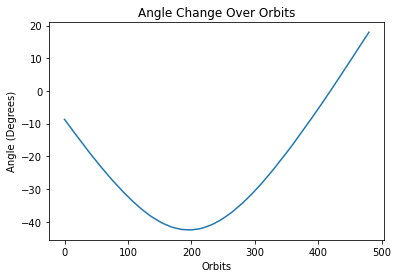

In [3]:
plt.title("Angle Change Over Orbits")
plt.xlabel("Orbits")
plt.ylabel("Angle (Degrees)")
plt.plot(iterator_orbits, orbit_angles)

In [ ]:
Given power analysis per orbit for solar panels is done, now require analysis per orbit considering other components such as
magnetorquers, gyro, obc, transceiver. 

In [ ]:
Magnetorquers, gyro and obc are always on; constant per every orbit

In [4]:
magnetorquer = -600
gyro = -12
obc = -800
power_used_platform_computing = (gyro + magnetorquer + obc) / 60 * 90 #all comp will use power for entire duration of 90-min orbit
print("OBC, ADCS per orbit: " + str(power_used_platform_computing))

OBC, ADCS per orbit: -2118.0


In [ ]:
Transceiver will transmit a certain time per each orbit, rest of time it will be receiving
Below analysis assumes single transmission per orbit, with following average time for transmission

In [5]:
transmission_data = pd.read_csv("Satellite-ISS_UNITY_25575-To-Facility-London_April22_Access.csv")
mean_transmit_time = transmission_data['Duration (sec)'].mean()/60/60
print('Average transmission time (mins): April - May 2022: ' + str(mean_transmit_time) + " hours") 

Average transmission time (mins): April - May 2022: 0.09202910202991453 hours


In [6]:
uhf_transceiver_transmit = 1140
uhf_transceiver_receive = 0.0825

power_used_transceiver = uhf_transceiver_transmit/60*mean_transmit_time*(-1) + uhf_transceiver_receive/60*(90-mean_transmit_time)*(-1)
print("Transceiver per orbit: " + str(power_used_transceiver))

Transceiver per orbit: -1.8721763985530848


In [ ]:
Visualize power generation over a few orbits to see structure per orbit

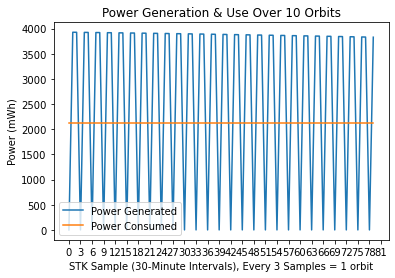

In [8]:
solar_power_sample = []
iterator_sample = []
all_comp = power_used_transceiver + power_used_platform_computing * (-1)
all_comp_data_sample = []

for i in range(80):
    solar_power_sample.append(solar_power[i])
    iterator_sample.append(i)
    all_comp_data_sample.append(all_comp)

plt.xticks(range(0, len(iterator), 3))
plt.title("Power Generation & Use Over 10 Orbits")
plt.xlabel("STK Sample (30-Minute Intervals), Every 3 Samples = 1 orbit")
plt.ylabel("Power (mWh)")

power_gen, = plt.plot(iterator_sample, solar_power_sample)
power_used, = plt.plot(iterator_sample, all_comp_data_sample)
legend = plt.legend((power_gen, power_used), ('Power Generated', 'Power Consumed'))
plt.show()

In [ ]:
Visualize power generation over entire period to see how beta angle affects power generation over time 

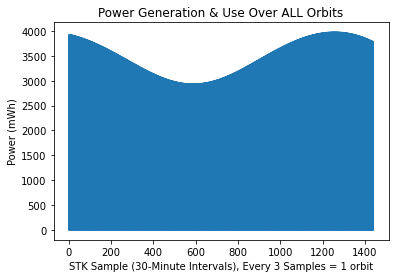

In [9]:
plt.title("Power Generation Over ALL Orbits")
plt.xlabel("STK Sample (30-Minute Intervals), Every 3 Samples = 1 orbit")
plt.ylabel("Power (mWh)")

power_gen, = plt.plot(iterator, solar_power)
#power_used, = plt.plot(iterator, all_comp_data)
#legend = plt.legend((power_gen, power_used), ('Power Generated', 'Power Consumed'))

plt.show()

In [ ]:
Combine all components per every orbit and iterate through all orbits as sun angles change

Total energy remaining: 296014.81918596395 mWh after conducting: 480 orbits
Period of analysis: 2022-04-01 12:00:00 AM to 2022-05-01 12:00:00 AM
Hours satellite remains without power: 240.5hours


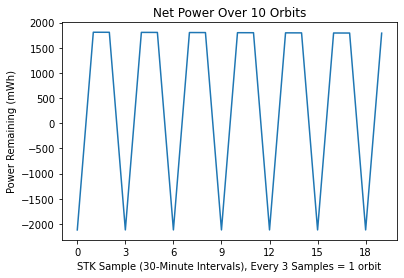

In [19]:
total_power = []
when_power_negative = []
time_without_power = 0 
power_generated = 0
when_power_negative_sample = []

total_power_sample = []
iterator_sample = []


for i in range(len(beta_angles)): 
    power_all_comp = solar_power[i] + power_used_transceiver + power_used_platform_computing
    power_generated += power_all_comp
    total_power.append(power_all_comp)
    
    #Keep track of when satellite in power deficit to know when to rely on battery power 
    if(power_all_comp < 0):
        when_power_negative.append(1)
        time_without_power += 1
    else:
        when_power_negative.append(0)
        
time_without_power /= 2 #convert 30-min intervals to hours 


for i in range(20):
    total_power_sample.append(total_power[i])
    iterator_sample.append(i)
    when_power_negative_sample.append(when_power_negative[i])
    
plt.xticks(range(0, len(iterator), 3))
plt.title("Net Power Over 10 Orbits")
plt.xlabel("STK Sample (30-Minute Intervals), Every 3 Samples = 1 orbit")
plt.ylabel("Power Remaining (mWh)")
plt.plot(iterator_sample, total_power_sample)
print("Total energy remaining: " + str(power_generated) + " mWh after conducting: " + str(int(orbits)) + " orbits")
print("Period of analysis: " + str(dates[0]) + " to " + str(dates.iloc[-1]))
print("Hours satellite remains without power: " + str(time_without_power) + "hours")

In [ ]:
Below is plot of when power is in deficit (indicated by 1) and when it is in surplus (indicated by 0)
Overall periods of power surplus are longer (by observation) than periods of power deficit
Implies that for periods where step function == 1, satellite must used stored power for operation as solar panels insufficent
From analysis it appears that satellite remains 120.5 hours without power; necessary to check if battery can work in that period

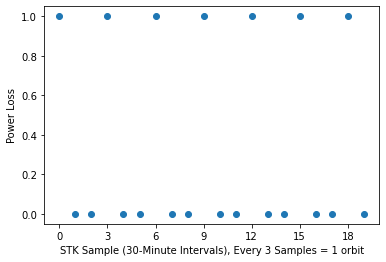

In [20]:
plt.xticks(range(0, len(iterator), 3))
plt.xlabel("STK Sample (30-Minute Intervals), Every 3 Samples = 1 orbit")
plt.ylabel("Power Loss")
plt.scatter(iterator_sample, when_power_negative_sample)

In [ ]:
Evident that per each orbit, satellite enters power deficit for 2/3 of orbit (due to power consumption & eclipse)